# Eco Journey: Image Classification

> Dataset: https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2





## Setup

Import TensorFlow and library lainnya untuk Image Classification:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import zipfile
import imghdr
import os
import matplotlib.pyplot as plt

from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image_dataset_from_directory

## Load Dataset

Mengambil data dari Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Jalur ke file ZIP di Google Drive
zip_path = "/content/drive/Shared drives/Capstone/Image-Classification/waste-dataset.zip"

# Jalur lokal tempat file ZIP nya akan disalin di Colab
local_zip_path = "/content/waste-dataset.zip"

# Salin file ZIP dari Google Drive ke instance lokal Colab
!cp "{zip_path}" "{local_zip_path}"

# Extract file ZIP
with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/waste-dataset")

# Menetapkan direktori data setelah di ekstrak
data_dir = "/content/waste-dataset"

Mounted at /content/drive


In [ ]:
data_dir = "/content/waste-dataset"
classes = os.listdir(data_dir)

In [ ]:
print("Ditemukan sub-folder di dalam dataset:")
for class_name in classes:
    print(class_name)

Ditemukan sub-folder di dalam dataset:
metal
clothes
paper
glass
trash
biological
battery
cardboard
shoes
plastic


In [ ]:
count = 0
image_extensions = [".png", ".jpg"]
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

# Gunakan pathlib.Path untuk iterasi dan validasi file
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not recognized as an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type} file, not accepted by TensorFlow")
            os.remove(filepath)
            count += 1

print(f"Removed {count} images")


/content/waste-dataset/metal/metal_1441.jpg is not recognized as an image
/content/waste-dataset/paper/paper_2706.jpg is not recognized as an image
/content/waste-dataset/paper/paper_1516.jpg is not recognized as an image
/content/waste-dataset/paper/paper_3044.jpg is not recognized as an image
/content/waste-dataset/paper/paper_2184.jpg is not recognized as an image
/content/waste-dataset/paper/paper_1068.jpg is not recognized as an image
/content/waste-dataset/paper/paper_779.jpg is not recognized as an image
/content/waste-dataset/paper/paper_2779.jpg is not recognized as an image
/content/waste-dataset/paper/paper_1433.jpg is not recognized as an image
/content/waste-dataset/paper/paper_1082.jpg is not recognized as an image
/content/waste-dataset/paper/paper_719.jpg is not recognized as an image
/content/waste-dataset/paper/paper_964.jpg is not recognized as an image
/content/waste-dataset/paper/paper_1640.jpg is not recognized as an image
/content/waste-dataset/glass/glass_4463.j

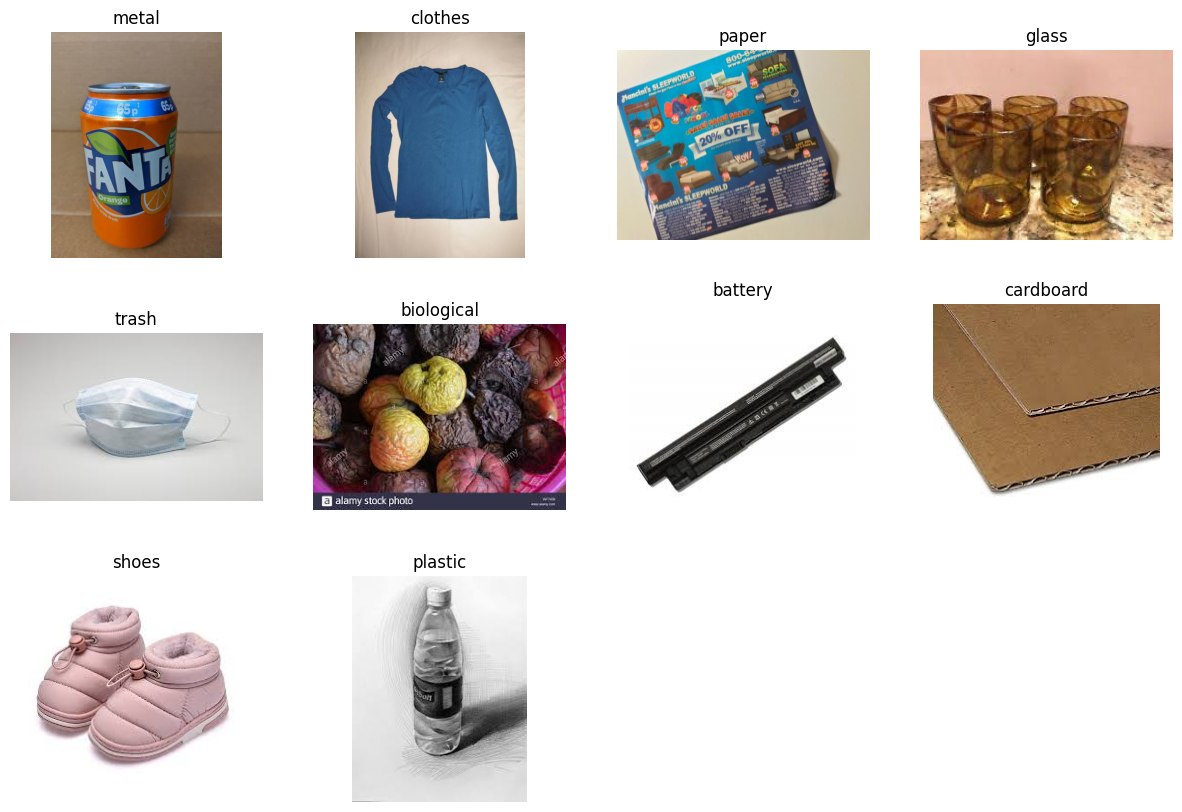

In [ ]:
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(classes):
    # Mengambil 1 gambar tiap label/subfolder
    class_dir = os.path.join(data_dir, class_name)
    file_names = os.listdir(class_dir)
    file_name = os.path.join(class_dir, file_names[2])

    # MEnampilkan gambar
    img = plt.imread(file_name)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")

plt.show()

## Preprocessing

### Membuat Dataset

Menentukan beberapa parameter untuk loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Membagi 80% gambar untuk pelatihan dan 20% untuk validasi.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 23639 files belonging to 10 classes.
Using 18912 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 23639 files belonging to 10 classes.
Using 4727 files for validation.


Label yang terdapat pada folder:

In [ ]:
class_names = train_ds.class_names
print(class_names)

['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


In [ ]:
# train_ds = train_ds.repeat()

In [ ]:
# val_ds = val_ds.repeat()

## Visualisasi Data

Menampilkan 1 gambar pertama tiap label dari kumpulan data pelatihan:

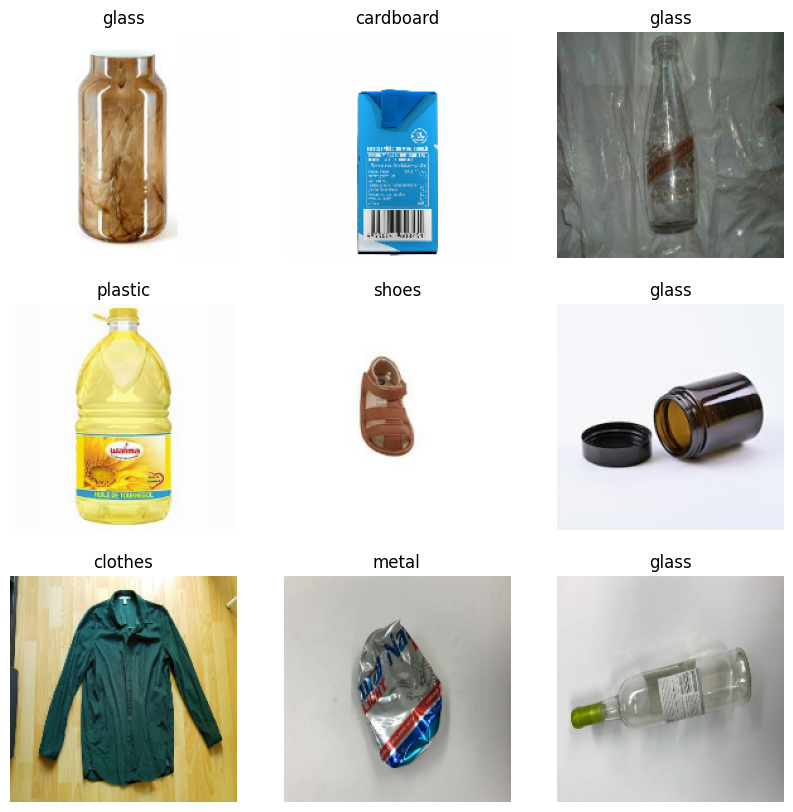

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


Memastikan data yang digunakan dalam pelatihan model sudah sesuai

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Meningkatkan kinerja pelatihan model dalam pengolahan dataset gambar, supaya lebih efisien dan efektif dalam memproses data nantinya

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standarisasi Data

Membakukan nilai agar berada dalam rentang [0, 1] dengan menggunakan tf.keras.layers.Rescaling:

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
def normalize_img(img, label):
    img = normalization_layer(img)
    return img, label

# Pastikan tensor gambar yang ada dalam dataset valid sebelum normalisasi
def filter_valid_images(img, label):
    return tf.reduce_all(tf.not_equal(img, None))

# Langsung memproses dataset tanpa membaca file lagi
def preprocess_dataset(ds):
    ds = ds.filter(filter_valid_images)
    ds = ds.map(normalize_img)
    return ds

## Model

### Buat modelnya menggunakan CNN

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Kompilasi modelnya

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Ringkasan model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Melatih model

In [ ]:
checkpoint_callback = ModelCheckpoint('model_checkpoint.h5',
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=False,
                                      verbose=1)

In [ ]:
epochs = 10
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[checkpoint_callback])

Epoch 1/10
589/591 [============================>.] - ETA: 0s - loss: 1.4792 - accuracy: 0.4941
Epoch 1: val_loss improved from inf to 1.13801, saving model to model_checkpoint.h5
591/591 [==============================] - 64s 41ms/step - loss: 1.4775 - accuracy: 0.4947 - val_loss: 1.1380 - val_accuracy: 0.6063


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
591/591 [==============================] - ETA: 0s - loss: 0.9136 - accuracy: 0.6975
Epoch 2: val_loss improved from 1.13801 to 0.82598, saving model to model_checkpoint.h5
591/591 [==============================] - 13s 21ms/step - loss: 0.9136 - accuracy: 0.6975 - val_loss: 0.8260 - val_accuracy: 0.7267
Epoch 3/10
590/591 [============================>.] - ETA: 0s - loss: 0.6094 - accuracy: 0.8008
Epoch 3: val_loss improved from 0.82598 to 0.78192, saving model to model_checkpoint.h5
591/591 [==============================] - 12s 21ms/step - loss: 0.6094 - accuracy: 0.8008 - val_loss: 0.7819 - val_accuracy: 0.7574
Epoch 4/10
589/591 [============================>.] - ETA: 0s - loss: 0.3637 - accuracy: 0.8815
Epoch 4: val_loss improved from 0.78192 to 0.76409, saving model to model_checkpoint.h5
591/591 [==============================] - 14s 23ms/step - loss: 0.3637 - accuracy: 0.8815 - val_loss: 0.7641 - val_accuracy: 0.7942
Epoch 5/10
591/591 [=============================

## Visualisasi hasil pelatihan

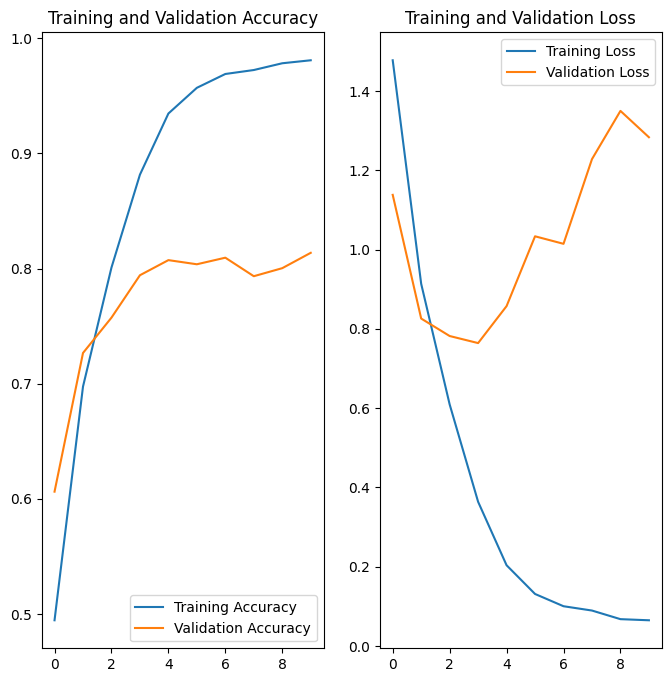

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Augmentasi Data

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualisasikan beberapa contoh augmented dengan menerapkan augmentasi data ke gambar yang sama beberapa kali:

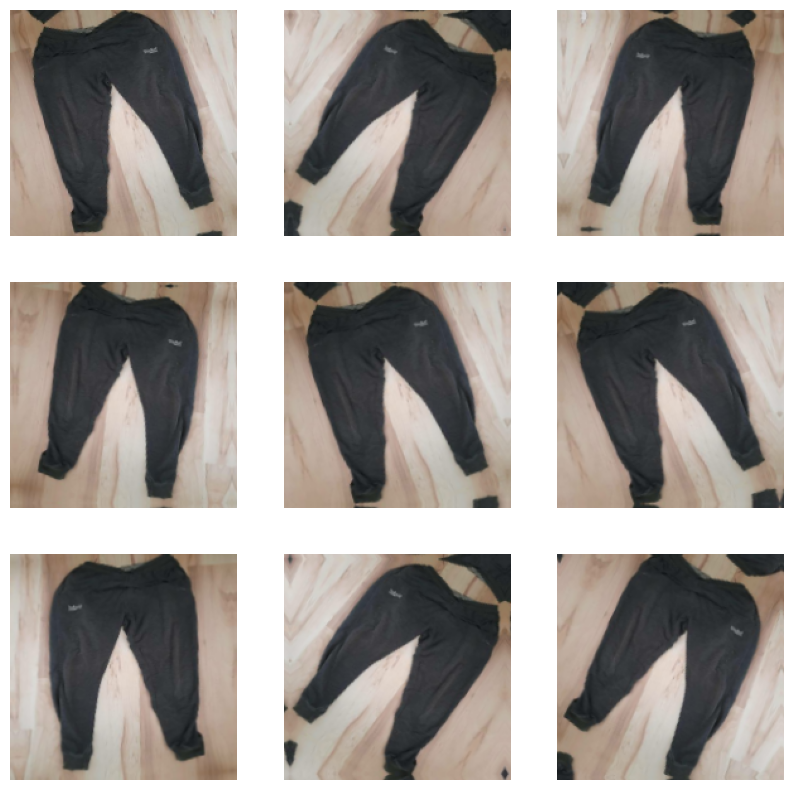

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout

Untuk mengurangi overfitting

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Kompilasi dan latih model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
591/591 [==============================] - 21s 30ms/step - loss: 1.5888 - accuracy: 0.4497 - val_loss: 1.3571 - val_accuracy: 0.5327
Epoch 2/15
591/591 [==============================] - 17s 29ms/step - loss: 1.2317 - accuracy: 0.5806 - val_loss: 1.0598 - val_accuracy: 0.6412
Epoch 3/15
591/591 [==============================] - 17s 29ms/step - loss: 1.0903 - accuracy: 0.6337 - val_loss: 0.9967 - val_accuracy: 0.6687
Epoch 4/15
591/591 [==============================] - 17s 29ms/step - loss: 0.9921 - accuracy: 0.6655 - val_loss: 0.9684 - val_accuracy: 0.6708
Epoch 5/15
591/591 [==============================] - 18s 30ms/step - loss: 0.9213 - accuracy: 0.6925 - val_loss: 1.0088 - val_accuracy: 0.6789
Epoch 6/15
591/591 [==============================] - 17s 29ms/step - loss: 0.8644 - accuracy: 0.7116 - val_loss: 0.8404 - val_accuracy: 0.7184
Epoch 7/15
591/591 [==============================] - 17s 29ms/step - loss: 0.8049 - accuracy: 0.7319 - val_loss: 0.8421 - val_accuracy:

## Visualisasi hasil pelatihan

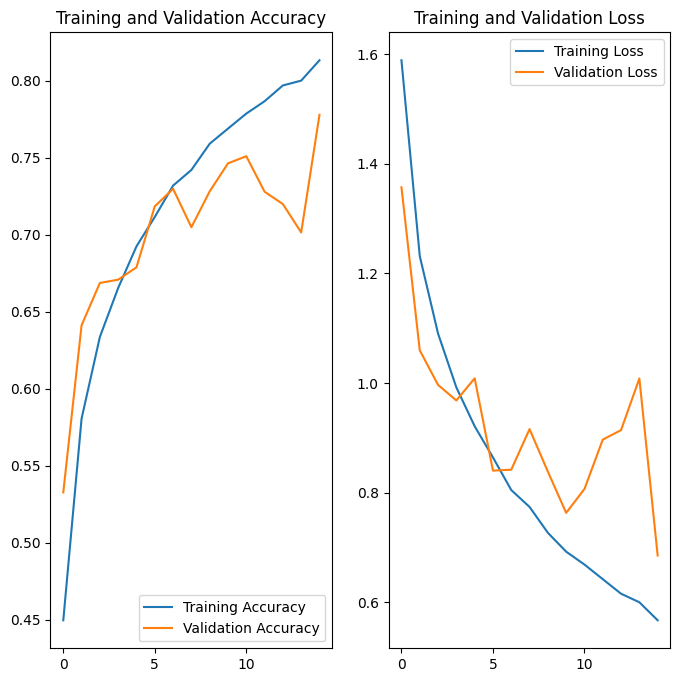

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prediksi data baru


In [ ]:
plastic_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/Botella_de_pl%C3%A1stico_-_PET.jpg/170px-Botella_de_pl%C3%A1stico_-_PET.jpg"
plastic_path = tf.keras.utils.get_file('plastic', origin=plastic_url)

img = tf.keras.utils.load_img(
    plastic_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "Gambar ini relate dengan {} dengan akurasi  {:.2f} persen."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 20ms/step
Gambar ini relate dengan plastic dengan akurasi  95.06 persen.


## Tensorflow Lite

### Convert model ke Tensorflow Lite (tflite)

In [ ]:
# Convert model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model.
with open('image_classification.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
!pip install tflite-support

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 29.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Ubah path sesuai dengan lokasi model TFLite di Google Drive Anda
model_path = 'https://drive.google.com/drive/folders/1A-dMKX6zOx7rxrQm3c7X_M4Vim3sbMU_?usp=sharing'

# Copy model TFLite ke folder Colab
!cp "$model_path" "/content/"

Mounted at /content/drive
cp: cannot stat 'https://drive.google.com/drive/folders/1A-dMKX6zOx7rxrQm3c7X_M4Vim3sbMU_?usp=sharing': No such file or directory
